In [1]:
import pandas as pd

In [2]:
scores = pd.read_csv("/Users/rezadoobary/Downloads/predictions_den_graph_data_12.csv")

In [5]:
scores.shape

(19212867, 3)

In [6]:
scores.head()

,y_true,y_prob,y_pred
0,0,5.590175e-14,0
1,0,2.810973e-16,0
2,0,5.426076e-21,0
3,1,1.793303e-01,0
4,1,8.013344e-01,1


In [14]:
# Quick data check
print(f"Data shape: {scores.shape}")
print(f"Columns: {scores.columns.tolist()}")
print(f"\nData summary:")
print(scores[['y_true', 'y_prob']].describe())
print(f"\nTarget distribution:")
print(scores['y_true'].value_counts())


Data shape: (19212867, 3)
Columns: ['y_true', 'y_prob', 'y_pred']

Data summary:
             y_true        y_prob
count  1.921287e+07  1.921287e+07
mean   2.524922e-01  2.289556e-01
std    4.344421e-01  4.061214e-01
min    0.000000e+00  0.000000e+00
25%    0.000000e+00  2.066467e-17
50%    0.000000e+00  5.503254e-11
75%    1.000000e+00  1.357721e-01
max    1.000000e+00  1.000000e+00

Target distribution:
y_true
0    14361767
1     4851100
Name: count, dtype: int64


In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss


In [16]:
def plot_calibration_curve(y_true, y_prob, n_bins=10, title='Calibration Plot'):
    """
    Plot calibration curve comparing predicted probabilities with actual frequencies
    
    Parameters:
    -----------
    y_true : array-like
        Ground truth binary labels (0 or 1)
    y_prob : array-like
        Model output probabilities
    n_bins : int
        Number of bins for calibration curve
    title : str
        Plot title
    """
    # Calculate calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, y_prob, n_bins=n_bins, strategy='uniform'
    )
    
    # Calculate Brier score
    brier = brier_score_loss(y_true, y_prob)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Calibration curve
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-", 
             label=f'Model (Brier={brier:.4f})', linewidth=2, markersize=8)
    ax1.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated", linewidth=2)
    ax1.set_xlabel('Mean Predicted Probability', fontsize=12)
    ax1.set_ylabel('Fraction of Positives', fontsize=12)
    ax1.set_title(f'{title} - Calibration Curve', fontsize=14, fontweight='bold')
    ax1.legend(loc="lower right", fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    
    # Histogram of predicted probabilities
    ax2.hist(y_prob, bins=n_bins, edgecolor='black', alpha=0.7, color='skyblue')
    ax2.set_xlabel('Predicted Probability', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Distribution of Predicted Probabilities', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    return fraction_of_positives, mean_predicted_value, brier


In [17]:
def plot_calibration_detailed(y_true, y_prob, n_bins=10, title='Calibration Plot'):
    """
    Create a detailed calibration plot with bin statistics
    
    Parameters:
    -----------
    y_true : array-like
        Ground truth binary labels (0 or 1)
    y_prob : array-like
        Model output probabilities
    n_bins : int
        Number of bins for calibration curve
    title : str
        Plot title
    """
    # Create bins
    bins = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(y_prob, bins) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    # Calculate statistics for each bin
    bin_stats = []
    for i in range(n_bins):
        mask = bin_indices == i
        if np.sum(mask) > 0:
            bin_mean_pred = np.mean(y_prob[mask])
            bin_mean_true = np.mean(y_true[mask])
            bin_count = np.sum(mask)
            bin_stats.append({
                'bin': i,
                'mean_pred': bin_mean_pred,
                'mean_true': bin_mean_true,
                'count': bin_count
            })
    
    bin_stats_df = pd.DataFrame(bin_stats)
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Calibration curve (top left)
    ax1 = axes[0, 0]
    if len(bin_stats_df) > 0:
        ax1.plot(bin_stats_df['mean_pred'], bin_stats_df['mean_true'], 
                'o-', linewidth=2, markersize=8, label='Model')
    ax1.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect calibration')
    ax1.set_xlabel('Mean Predicted Probability', fontsize=11)
    ax1.set_ylabel('Mean Actual Fraction', fontsize=11)
    ax1.set_title('Calibration Curve', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    
    # 2. Reliability diagram with counts (top right)
    ax2 = axes[0, 1]
    if len(bin_stats_df) > 0:
        bars = ax2.bar(bin_stats_df['mean_pred'], bin_stats_df['mean_true'] - bin_stats_df['mean_pred'],
                      width=0.08, alpha=0.7, color='coral', edgecolor='black')
        ax2.axhline(y=0, color='k', linestyle='--', linewidth=1)
        ax2.set_xlabel('Mean Predicted Probability', fontsize=11)
        ax2.set_ylabel('Difference (Actual - Predicted)', fontsize=11)
        ax2.set_title('Reliability Diagram (Over/Under-estimation)', fontsize=13, fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')
        
        # Add count labels on bars
        for i, (bar, count) in enumerate(zip(bars, bin_stats_df['count'])):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'n={count}', ha='center', va='bottom' if height >= 0 else 'top',
                    fontsize=8)
    
    # 3. Distribution of predictions (bottom left)
    ax3 = axes[1, 0]
    ax3.hist(y_prob, bins=n_bins, edgecolor='black', alpha=0.7, color='skyblue')
    ax3.set_xlabel('Predicted Probability', fontsize=11)
    ax3.set_ylabel('Frequency', fontsize=11)
    ax3.set_title('Distribution of Predicted Probabilities', fontsize=13, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Sample size per bin (bottom right)
    ax4 = axes[1, 1]
    if len(bin_stats_df) > 0:
        ax4.bar(range(len(bin_stats_df)), bin_stats_df['count'], 
               edgecolor='black', alpha=0.7, color='lightgreen')
        ax4.set_xlabel('Bin Index', fontsize=11)
        ax4.set_ylabel('Sample Count', fontsize=11)
        ax4.set_title('Sample Size per Bin', fontsize=13, fontweight='bold')
        ax4.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle(title, fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    brier = brier_score_loss(y_true, y_prob)
    print(f"\nCalibration Summary:")
    print(f"Brier Score: {brier:.4f} (lower is better, 0 = perfect)")
    print(f"Number of samples: {len(y_true)}")
    print(f"Number of bins: {n_bins}")
    if len(bin_stats_df) > 0:
        print(f"\nBin Statistics:")
        print(bin_stats_df.to_string(index=False))
    
    return bin_stats_df


In [18]:
# Extract ground truth and model probabilities
y_true = scores['y_true'].values
y_prob = scores['y_prob'].values

# Check for any NaN values
mask = ~(np.isnan(y_prob) | np.isnan(y_true))
y_true_clean = y_true[mask]
y_prob_clean = y_prob[mask]

print(f"Total samples: {len(y_true)}")
print(f"Valid samples (after removing NaN): {len(y_true_clean)}")
print(f"y_prob range: [{y_prob_clean.min():.4f}, {y_prob_clean.max():.4f}]")
print(f"y_true unique values: {np.unique(y_true_clean)}")


Total samples: 19212867
Valid samples (after removing NaN): 19212867
y_prob range: [0.0000, 1.0000]
y_true unique values: [0 1]


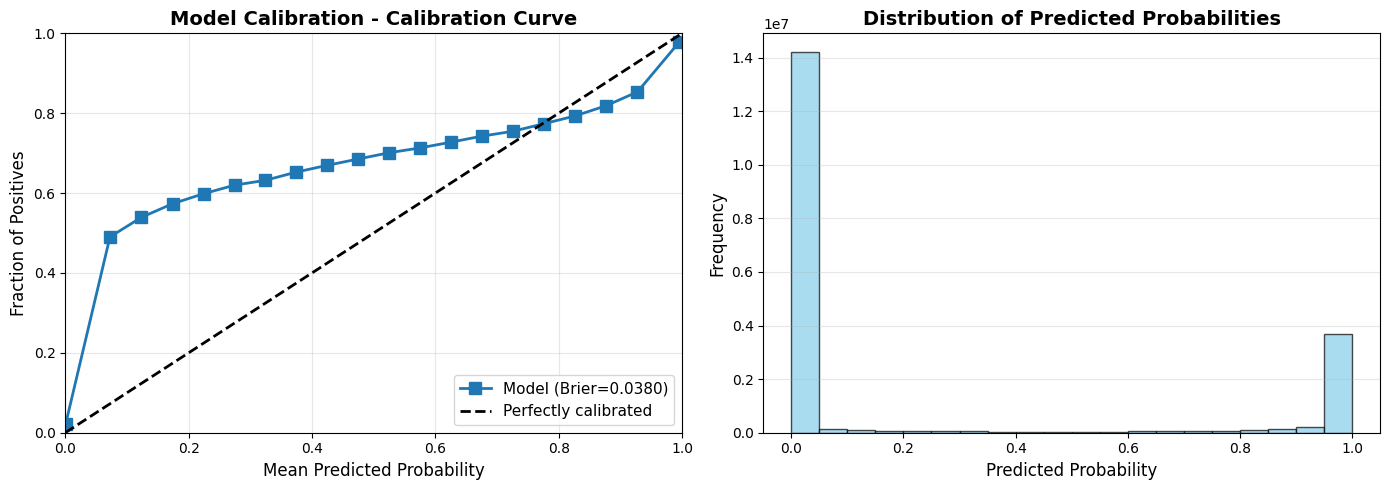

(array([0.02228414, 0.4903329 , 0.5394022 , 0.57348985, 0.59853555,
        0.61993836, 0.63203482, 0.65271506, 0.66953942, 0.6853717 ,
        0.70101973, 0.71313448, 0.72748452, 0.74257464, 0.75471436,
        0.77361836, 0.79302213, 0.81871063, 0.85343903, 0.97878995]),
 array([6.57649093e-04, 7.24660286e-02, 1.23590224e-01, 1.74138502e-01,
        2.24460543e-01, 2.74666301e-01, 3.24624069e-01, 3.74824112e-01,
        4.24804942e-01, 4.75057049e-01, 5.25080413e-01, 5.75400760e-01,
        6.25313435e-01, 6.75455220e-01, 7.25613676e-01, 7.75811031e-01,
        8.26259194e-01, 8.76769055e-01, 9.27821069e-01, 9.95852944e-01]),
 0.037951003392599894)

In [20]:
# Standard Calibration Plot
plot_calibration_curve(y_true_clean, y_prob_clean, n_bins=20, title='Model Calibration')


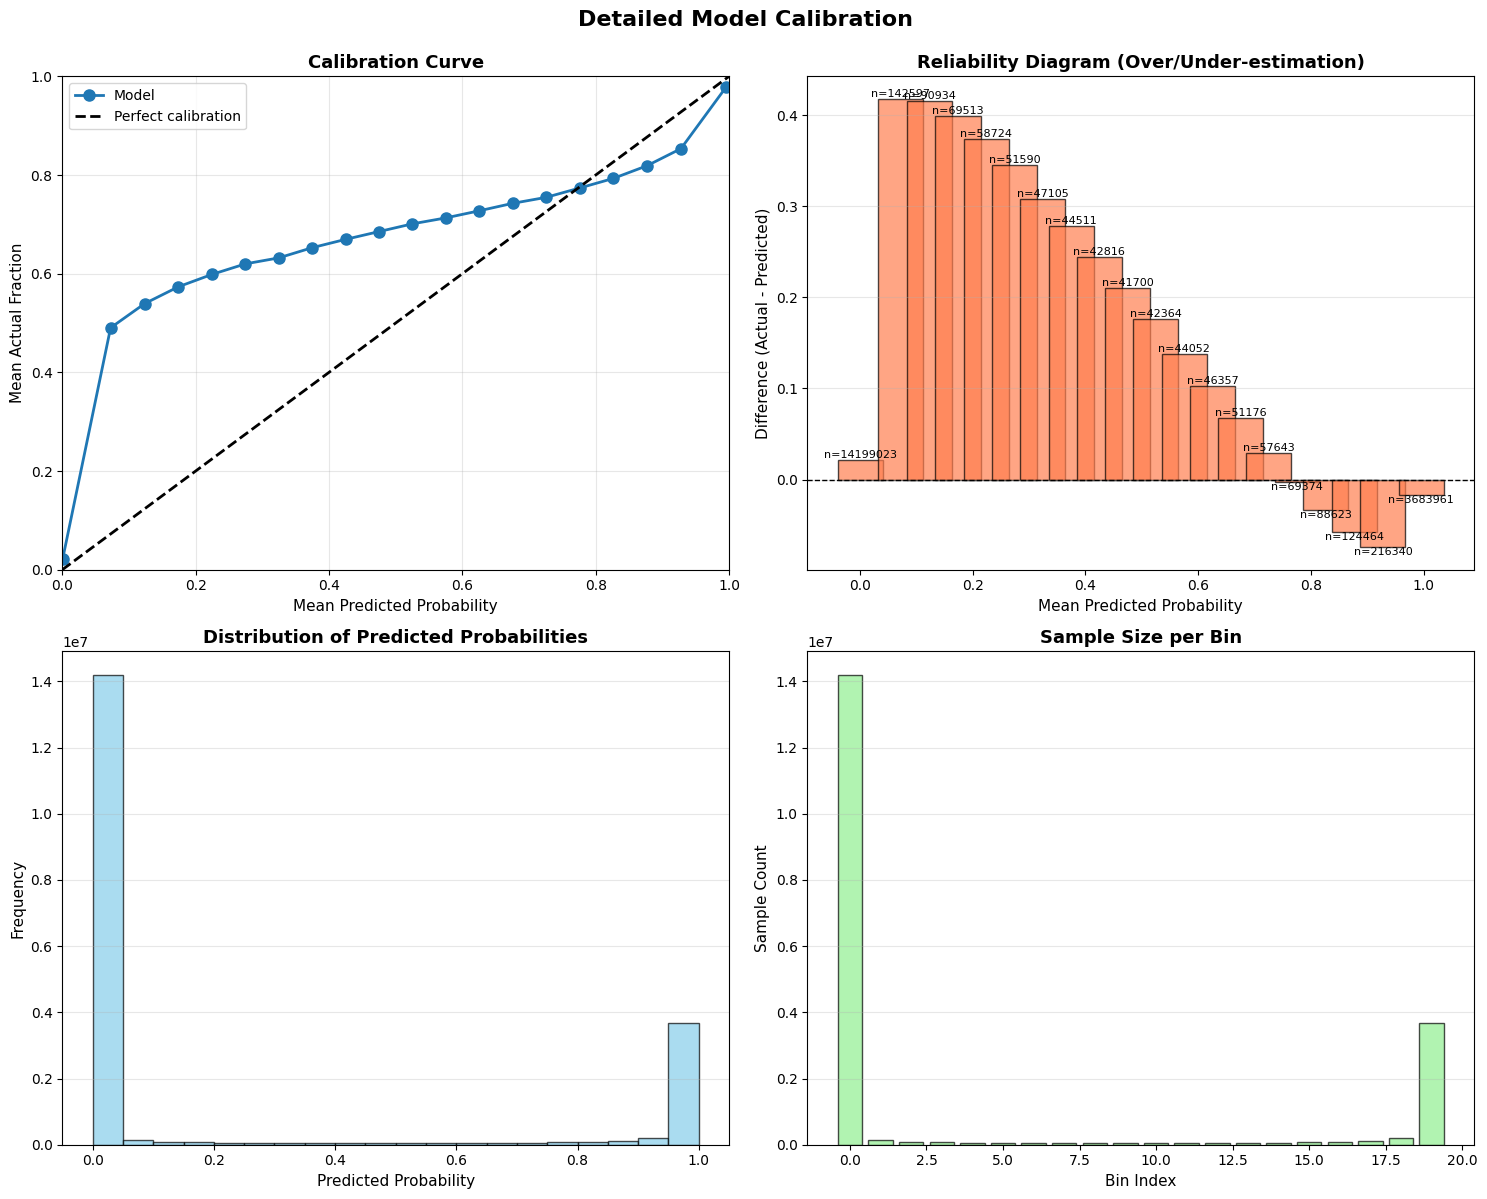


Calibration Summary:
Brier Score: 0.0380 (lower is better, 0 = perfect)
Number of samples: 19212867
Number of bins: 20

Bin Statistics:
 bin  mean_pred  mean_true    count
   0   0.000658   0.022284 14199023
   1   0.072466   0.490333   142597
   2   0.123590   0.539402    90934
   3   0.174139   0.573490    69513
   4   0.224460   0.598546    58724
   5   0.274666   0.619926    51590
   6   0.324624   0.632035    47105
   7   0.374824   0.652715    44511
   8   0.424805   0.669539    42816
   9   0.475057   0.685372    41700
  10   0.525080   0.701020    42364
  11   0.575401   0.713134    44052
  12   0.625313   0.727485    46357
  13   0.675455   0.742575    51176
  14   0.725614   0.754714    57643
  15   0.775811   0.773618    69374
  16   0.826259   0.793022    88623
  17   0.876769   0.818711   124464
  18   0.927821   0.853439   216340
  19   0.995853   0.978790  3683961


,bin,mean_pred,mean_true,count
0,0,0.000658,0.022284,14199023
1,1,0.072466,0.490333,142597
2,2,0.123590,0.539402,90934
3,3,0.174139,0.573490,69513
4,4,0.224460,0.598546,58724
5,5,0.274666,0.619926,51590
6,6,0.324624,0.632035,47105
7,7,0.374824,0.652715,44511
8,8,0.424805,0.669539,42816
9,9,0.475057,0.685372,41700


In [21]:
# Detailed Calibration Plot with Statistics
plot_calibration_detailed(y_true_clean, y_prob_clean, n_bins=20, title='Detailed Model Calibration')


In [24]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

def plot_precision_recall_fpr_tpr(y_true, y_prob, n_thresholds=1000):
    """
    Plot precision, recall, FPR, and TPR as functions of threshold
    
    Parameters:
    -----------
    y_true : array-like
        Ground truth binary labels (0 or 1)
    y_prob : array-like
        Model output probabilities
    n_thresholds : int
        Number of threshold points to evaluate
    """
    # Calculate precision-recall curve
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_prob)
    
    # Calculate ROC curve (TPR vs FPR)
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_prob)
    
    # Calculate AUC
    pr_auc = auc(recall, precision)
    roc_auc = auc(fpr, tpr)
    
    # Create figure with subplots
    fig = plt.figure(figsize=(16, 10))
    
    # 1. Precision and Recall vs Threshold (top left)
    ax1 = plt.subplot(2, 2, 1)
    # Use a subset of thresholds for cleaner visualization
    step = max(1, len(pr_thresholds) // n_thresholds)
    pr_thresh_subset = pr_thresholds[::step]
    precision_subset = precision[1::step]  # Skip first value (threshold=1.0)
    recall_subset = recall[1::step]
    
    ax1.plot(pr_thresh_subset, precision_subset, 'b-', label='Precision', linewidth=2)
    ax1.plot(pr_thresh_subset, recall_subset, 'r-', label='Recall', linewidth=2)
    ax1.set_xlabel('Threshold', fontsize=12)
    ax1.set_ylabel('Score', fontsize=12)
    ax1.set_title(f'Precision and Recall vs Threshold (PR-AUC: {pr_auc:.4f})', 
                  fontsize=13, fontweight='bold')
    ax1.legend(loc='best', fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    
    # 2. FPR and TPR vs Threshold (top right)
    ax2 = plt.subplot(2, 2, 2)
    # Use a subset of thresholds for cleaner visualization
    step = max(1, len(roc_thresholds) // n_thresholds)
    roc_thresh_subset = roc_thresholds[::step]
    fpr_subset = fpr[::step]
    tpr_subset = tpr[::step]
    
    ax2.plot(roc_thresh_subset, tpr_subset, 'g-', label='TPR (Sensitivity)', linewidth=2)
    ax2.plot(roc_thresh_subset, fpr_subset, 'orange', label='FPR (1 - Specificity)', linewidth=2)
    ax2.set_xlabel('Threshold', fontsize=12)
    ax2.set_ylabel('Rate', fontsize=12)
    ax2.set_title(f'TPR and FPR vs Threshold (ROC-AUC: {roc_auc:.4f})', 
                  fontsize=13, fontweight='bold')
    ax2.legend(loc='best', fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])
    
    # 3. Precision-Recall Curve (bottom left)
    ax3 = plt.subplot(2, 2, 3)
    ax3.plot(recall, precision, 'b-', linewidth=2, label=f'PR Curve (AUC={pr_auc:.4f})')
    ax3.set_xlabel('Recall', fontsize=12)
    ax3.set_ylabel('Precision', fontsize=12)
    ax3.set_title('Precision-Recall Curve', fontsize=13, fontweight='bold')
    ax3.legend(loc='best', fontsize=11)
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim([0, 1])
    ax3.set_ylim([0, 1])
    
    # 4. ROC Curve (bottom right)
    ax4 = plt.subplot(2, 2, 4)
    ax4.plot(fpr, tpr, 'g-', linewidth=2, label=f'ROC Curve (AUC={roc_auc:.4f})')
    ax4.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
    ax4.set_xlabel('False Positive Rate (FPR)', fontsize=12)
    ax4.set_ylabel('True Positive Rate (TPR)', fontsize=12)
    ax4.set_title('ROC Curve', fontsize=13, fontweight='bold')
    ax4.legend(loc='lower right', fontsize=11)
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim([0, 1])
    ax4.set_ylim([0, 1])
    
    plt.suptitle('Classification Performance Metrics', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics at different thresholds
    print("\n" + "="*80)
    print("Performance Metrics at Different Thresholds")
    print("="*80)
    
    test_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    print(f"\n{'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'TPR':<12} {'FPR':<12}")
    print("-" * 80)
    
    for thresh in test_thresholds:
        y_pred_thresh = (y_prob >= thresh).astype(int)
        prec = precision_score(y_true, y_pred_thresh, zero_division=0)
        rec = recall_score(y_true, y_pred_thresh, zero_division=0)
        f1 = f1_score(y_true, y_pred_thresh, zero_division=0)
        
        # Calculate TPR and FPR manually
        tp = np.sum((y_pred_thresh == 1) & (y_true == 1))
        fp = np.sum((y_pred_thresh == 1) & (y_true == 0))
        tn = np.sum((y_pred_thresh == 0) & (y_true == 0))
        fn = np.sum((y_pred_thresh == 0) & (y_true == 1))
        
        tpr_val = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr_val = fp / (fp + tn) if (fp + tn) > 0 else 0
        
        print(f"{thresh:<12.1f} {prec:<12.4f} {rec:<12.4f} {f1:<12.4f} {tpr_val:<12.4f} {fpr_val:<12.4f}")
    
    print("\n" + "="*80)
    print(f"Overall Metrics:")
    print(f"  PR-AUC: {pr_auc:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")
    print("="*80)
    
    return {
        'precision': precision,
        'recall': recall,
        'pr_thresholds': pr_thresholds,
        'fpr': fpr,
        'tpr': tpr,
        'roc_thresholds': roc_thresholds,
        'pr_auc': pr_auc,
        'roc_auc': roc_auc
    }


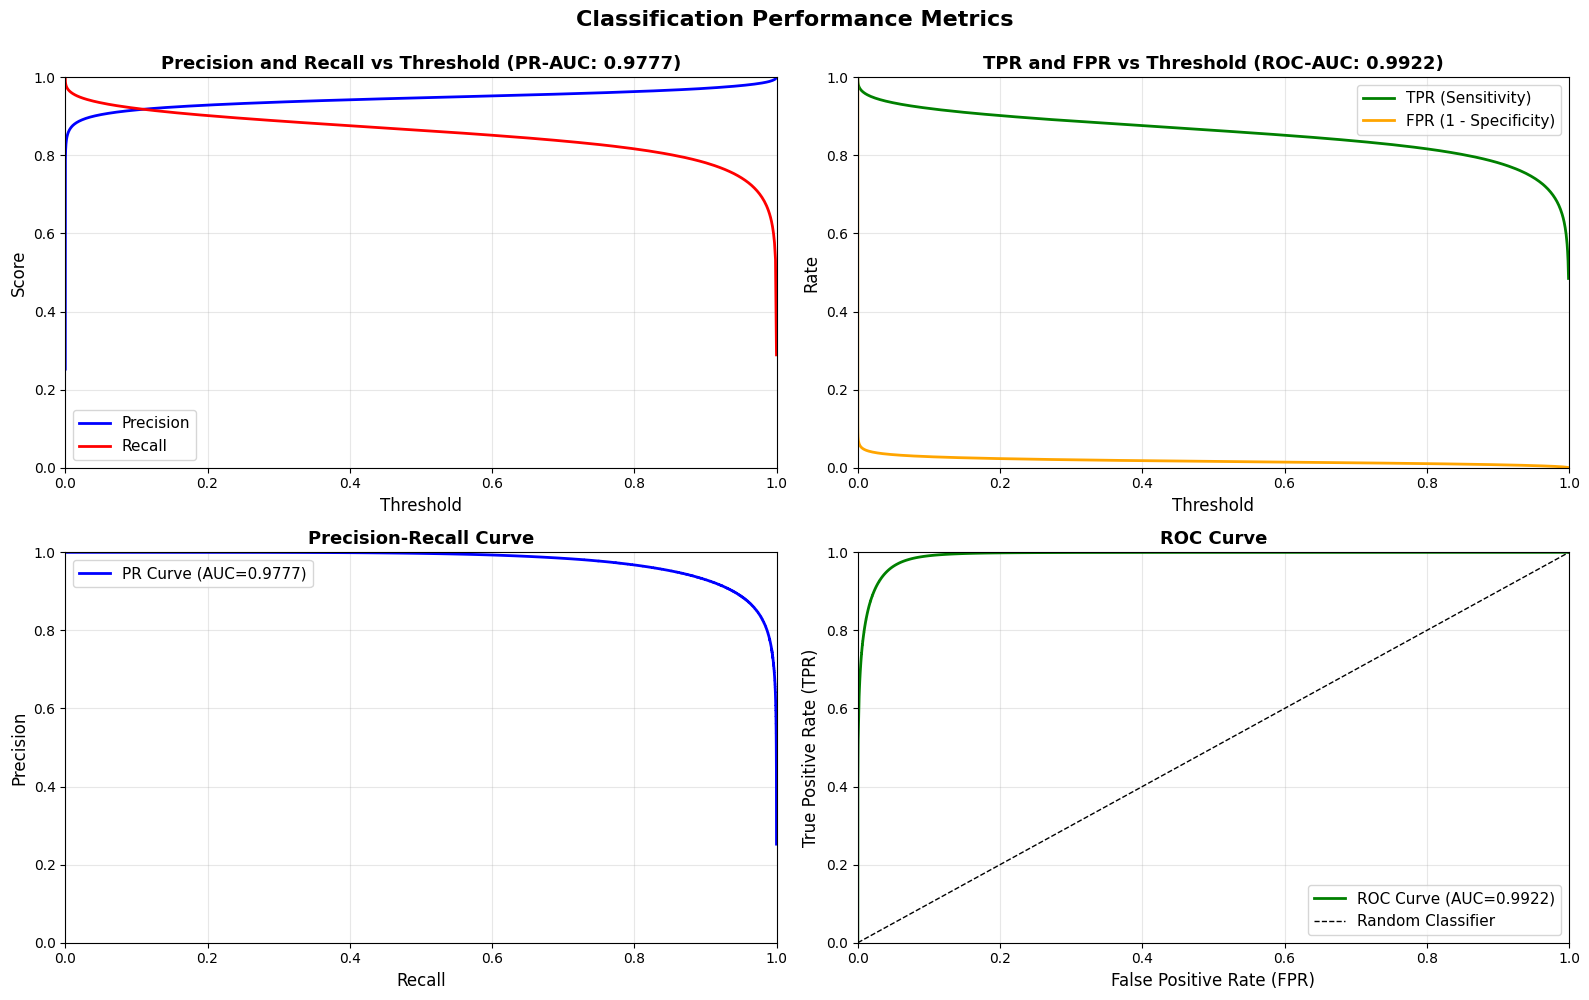


Performance Metrics at Different Thresholds

Threshold    Precision    Recall       F1-Score     TPR          FPR         
--------------------------------------------------------------------------------
0.1          0.9166       0.9204       0.9185       0.9204       0.0283      
0.2          0.9289       0.9020       0.9153       0.9020       0.0233      
0.3          0.9366       0.8882       0.9117       0.8882       0.0203      
0.4          0.9426       0.8761       0.9081       0.8761       0.0180      
0.5          0.9476       0.8643       0.9040       0.8643       0.0161      
0.6          0.9524       0.8517       0.8992       0.8517       0.0144      
0.7          0.9574       0.8369       0.8931       0.8369       0.0126      
0.8          0.9634       0.8169       0.8841       0.8169       0.0105      
0.9          0.9718       0.7814       0.8663       0.7814       0.0076      

Overall Metrics:
  PR-AUC: 0.9777
  ROC-AUC: 0.9922


In [25]:
# Plot precision, recall, FPR, and TPR as functions of threshold
metrics = plot_precision_recall_fpr_tpr(y_true_clean, y_prob_clean, n_thresholds=1000)


In [43]:
from sklearn.model_selection import train_test_split
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

class ConformalPredictor:
    """
    Conformal Prediction for binary classification using split conformal method.
    
    Provides prediction sets/intervals with guaranteed coverage properties.
    """
    
    def __init__(self, alpha=0.1):
        """
        Parameters:
        -----------
        alpha : float
            Significance level (1 - coverage). Default 0.1 means 90% coverage.
        """
        self.alpha = alpha
        self.quantile = None
        self.calibration_scores = None
        
    def compute_nonconformity_scores(self, y_true, y_prob):
        """
        Compute nonconformity scores.
        For binary classification: score = 1 - predicted_probability_for_true_class
        
        Parameters:
        -----------
        y_true : array-like
            True labels (0 or 1)
        y_prob : array-like
            Predicted probabilities for class 1
        
        Returns:
        --------
        scores : array
            Nonconformity scores
        """
        # Convert probabilities to array format [prob_class_0, prob_class_1]
        prob_class_0 = 1 - y_prob
        prob_class_1 = y_prob
        
        # Nonconformity score: 1 - probability assigned to true class
        scores = np.where(y_true == 0, 1 - prob_class_0, 1 - prob_class_1)
        return scores
    
    def fit(self, y_true_cal, y_prob_cal):
        """
        Fit the conformal predictor on calibration data.
        
        Parameters:
        -----------
        y_true_cal : array-like
            True labels for calibration set
        y_prob_cal : array-like
            Predicted probabilities for calibration set
        """
        # Compute nonconformity scores on calibration set
        self.calibration_scores = self.compute_nonconformity_scores(y_true_cal, y_prob_cal)
        
        # Compute quantile for prediction sets
        # Use (1-alpha) quantile with finite-sample correction
        n = len(self.calibration_scores)
        quantile_level = np.ceil((n + 1) * (1 - self.alpha)) / n
        self.quantile = np.quantile(self.calibration_scores, quantile_level, method='higher')
        
        print(f"Calibration set size: {n}")
        print(f"Quantile level: {quantile_level:.4f}")
        print(f"Quantile value (threshold): {self.quantile:.6f}")
        print(f"Target coverage: {1 - self.alpha:.1%}")
        
    def predict(self, y_prob_test):
        """
        Generate prediction sets for test data.
        
        Parameters:
        -----------
        y_prob_test : array-like
            Predicted probabilities for test set
        
        Returns:
        --------
        prediction_sets : array
            Prediction sets (0: only class 0, 1: only class 1, 2: both classes)
        prediction_intervals : array
            Prediction intervals for probability of class 1
        """
        y_prob_test = np.array(y_prob_test)
        n_test = len(y_prob_test)
        
        # Compute nonconformity scores for each possible label
        # For class 0: score = 1 - (1 - y_prob) = y_prob
        # For class 1: score = 1 - y_prob
        scores_class_0 = y_prob_test
        scores_class_1 = 1 - y_prob_test
        
        # Include class in prediction set if nonconformity score <= quantile
        include_class_0 = scores_class_0 <= self.quantile
        include_class_1 = scores_class_1 <= self.quantile
        
        # Create prediction sets: 0=only class 0, 1=only class 1, 2=both
        prediction_sets = np.zeros(n_test, dtype=int)
        prediction_sets[include_class_0 & ~include_class_1] = 0
        prediction_sets[~include_class_0 & include_class_1] = 1
        prediction_sets[include_class_0 & include_class_1] = 2
        
        # Compute prediction intervals for probability of class 1
        # Lower bound: max(0, y_prob - quantile)
        # Upper bound: min(1, y_prob + quantile)
        lower_bound = np.maximum(0, y_prob_test - self.quantile)
        upper_bound = np.minimum(1, y_prob_test + self.quantile)
        prediction_intervals = np.column_stack([lower_bound, upper_bound])
        
        return prediction_sets, prediction_intervals
    
    def evaluate_coverage(self, y_true_test, prediction_sets):
        """
        Evaluate empirical coverage on test set.
        
        Parameters:
        -----------
        y_true_test : array-like
            True labels for test set
        prediction_sets : array
            Prediction sets (0, 1, or 2)
        
        Returns:
        --------
        coverage : float
            Empirical coverage rate
        """
        y_true_test = np.array(y_true_test)
        prediction_sets = np.array(prediction_sets)
        
        # Check if true label is in prediction set
        covered = np.zeros(len(y_true_test), dtype=bool)
        covered[(y_true_test == 0) & (prediction_sets != 1)] = True  # Class 0 covered if set is 0 or 2
        covered[(y_true_test == 1) & (prediction_sets != 0)] = True  # Class 1 covered if set is 1 or 2
        
        coverage = np.mean(covered)
        return coverage
    
    def get_set_size_distribution(self, prediction_sets):
        """
        Get distribution of prediction set sizes.
        
        Parameters:
        -----------
        prediction_sets : array
            Prediction sets (0, 1, or 2)
        
        Returns:
        --------
        set_sizes : array
            Set sizes (1 for sets 0 or 1, 2 for set 2)
        """
        set_sizes = np.where(prediction_sets == 2, 2, 1)
        return set_sizes


In [44]:
def plot_conformal_results(cp, y_true_test, y_prob_test, prediction_sets, prediction_intervals, 
                           n_samples_plot=5000):
    """
    Visualize conformal prediction results.
    
    Parameters:
    -----------
    cp : ConformalPredictor
        Fitted conformal predictor
    y_true_test : array-like
        True labels for test set
    y_prob_test : array-like
        Predicted probabilities for test set
    prediction_sets : array
        Prediction sets
    prediction_intervals : array
        Prediction intervals
    n_samples_plot : int
        Number of samples to plot (for visualization clarity)
    """
    y_true_test = np.array(y_true_test)
    y_prob_test = np.array(y_prob_test)
    prediction_sets = np.array(prediction_sets)
    prediction_intervals = np.array(prediction_intervals)
    
    # Sample for plotting if dataset is large
    if len(y_true_test) > n_samples_plot:
        indices = np.random.choice(len(y_true_test), n_samples_plot, replace=False)
        y_true_plot = y_true_test[indices]
        y_prob_plot = y_prob_test[indices]
        pred_sets_plot = prediction_sets[indices]
        pred_intervals_plot = prediction_intervals[indices]
    else:
        y_true_plot = y_true_test
        y_prob_plot = y_prob_test
        pred_sets_plot = prediction_sets
        pred_intervals_plot = prediction_intervals
    
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Calibration scores distribution (top left)
    ax1 = plt.subplot(2, 3, 1)
    ax1.hist(cp.calibration_scores, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
    ax1.axvline(cp.quantile, color='red', linestyle='--', linewidth=2, 
                label=f'Quantile threshold: {cp.quantile:.4f}')
    ax1.set_xlabel('Nonconformity Score', fontsize=11)
    ax1.set_ylabel('Frequency', fontsize=11)
    ax1.set_title('Calibration Set: Nonconformity Scores', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # 2. Prediction sets visualization (top middle)
    ax2 = plt.subplot(2, 3, 2)
    set_0_mask = pred_sets_plot == 0
    set_1_mask = pred_sets_plot == 1
    set_2_mask = pred_sets_plot == 2
    
    ax2.scatter(y_prob_plot[set_0_mask], y_true_plot[set_0_mask], 
               alpha=0.3, s=10, c='blue', label='Set: {0}', marker='o')
    ax2.scatter(y_prob_plot[set_1_mask], y_true_plot[set_1_mask], 
               alpha=0.3, s=10, c='red', label='Set: {1}', marker='s')
    ax2.scatter(y_prob_plot[set_2_mask], y_true_plot[set_2_mask], 
               alpha=0.3, s=10, c='purple', label='Set: {0,1}', marker='^')
    ax2.set_xlabel('Predicted Probability (Class 1)', fontsize=11)
    ax2.set_ylabel('True Label', fontsize=11)
    ax2.set_title('Prediction Sets', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=9, loc='upper right')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([-0.1, 1.1])
    
    # 3. Prediction intervals (top right)
    ax3 = plt.subplot(2, 3, 3)
    # Plot intervals for a subset
    n_plot_intervals = min(200, len(pred_intervals_plot))
    indices_interval = np.random.choice(len(pred_intervals_plot), n_plot_intervals, replace=False)
    
    for i, idx in enumerate(indices_interval):
        interval = pred_intervals_plot[idx]
        color = 'green' if interval[0] <= y_true_plot[idx] <= interval[1] else 'red'
        ax3.plot([interval[0], interval[1]], [i, i], 'o-', color=color, alpha=0.6, markersize=3)
        ax3.plot(y_prob_plot[idx], i, 'kx', markersize=4)
    
    ax3.set_xlabel('Probability (Class 1)', fontsize=11)
    ax3.set_ylabel('Sample Index', fontsize=11)
    ax3.set_title(f'Prediction Intervals (sample of {n_plot_intervals})', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='x')
    ax3.set_xlim([0, 1])
    
    # 4. Set size distribution (bottom left)
    ax4 = plt.subplot(2, 3, 4)
    set_sizes = cp.get_set_size_distribution(prediction_sets)
    unique_sizes, counts = np.unique(set_sizes, return_counts=True)
    ax4.bar(unique_sizes, counts, edgecolor='black', alpha=0.7, color='lightgreen')
    ax4.set_xlabel('Prediction Set Size', fontsize=11)
    ax4.set_ylabel('Count', fontsize=11)
    ax4.set_title('Distribution of Prediction Set Sizes', fontsize=12, fontweight='bold')
    ax4.set_xticks(unique_sizes)
    ax4.grid(True, alpha=0.3, axis='y')
    for size, count in zip(unique_sizes, counts):
        ax4.text(size, count, f'{count:,}\n({count/len(prediction_sets)*100:.1f}%)', 
                ha='center', va='bottom', fontsize=9)
    
    # 5. Coverage by probability bin (bottom middle)
    ax5 = plt.subplot(2, 3, 5)
    bins = np.linspace(0, 1, 11)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    coverage_by_bin = []
    
    for i in range(len(bins) - 1):
        mask = (y_prob_test >= bins[i]) & (y_prob_test < bins[i+1])
        if np.sum(mask) > 0:
            coverage = cp.evaluate_coverage(y_true_test[mask], prediction_sets[mask])
            coverage_by_bin.append(coverage)
        else:
            coverage_by_bin.append(np.nan)
    
    coverage_by_bin = np.array(coverage_by_bin)
    valid_mask = ~np.isnan(coverage_by_bin)
    ax5.plot(bin_centers[valid_mask], coverage_by_bin[valid_mask], 'o-', 
            linewidth=2, markersize=8, color='darkblue')
    ax5.axhline(1 - cp.alpha, color='red', linestyle='--', linewidth=2, 
               label=f'Target coverage: {1-cp.alpha:.1%}')
    ax5.set_xlabel('Predicted Probability (Class 1)', fontsize=11)
    ax5.set_ylabel('Empirical Coverage', fontsize=11)
    ax5.set_title('Coverage by Probability Bin', fontsize=12, fontweight='bold')
    ax5.legend(fontsize=10)
    ax5.grid(True, alpha=0.3)
    ax5.set_ylim([0, 1.05])
    
    # 6. Summary statistics (bottom right)
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    # Calculate statistics
    overall_coverage = cp.evaluate_coverage(y_true_test, prediction_sets)
    set_sizes = cp.get_set_size_distribution(prediction_sets)
    avg_set_size = np.mean(set_sizes)
    prop_single = np.mean(set_sizes == 1)
    prop_double = np.mean(set_sizes == 2)
    
    # Calculate interval width statistics
    interval_widths = prediction_intervals[:, 1] - prediction_intervals[:, 0]
    avg_width = np.mean(interval_widths)
    median_width = np.median(interval_widths)
    
    stats_text = f"""
    Conformal Prediction Summary
    
    Coverage Statistics:
    • Target coverage: {1-cp.alpha:.1%}
    • Empirical coverage: {overall_coverage:.4f} ({overall_coverage*100:.2f}%)
    • Coverage error: {abs(overall_coverage - (1-cp.alpha)):.4f}
    
    Prediction Set Statistics:
    • Average set size: {avg_set_size:.3f}
    • Single-class sets: {prop_single:.1%}
    • Multi-class sets: {prop_double:.1%}
    
    Interval Statistics:
    • Average width: {avg_width:.4f}
    • Median width: {median_width:.4f}
    • Min width: {np.min(interval_widths):.4f}
    • Max width: {np.max(interval_widths):.4f}
    
    Quantile Threshold: {cp.quantile:.6f}
    Test set size: {len(y_true_test):,}
    """
    
    ax6.text(0.1, 0.5, stats_text, fontsize=10, family='monospace',
            verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle(f'Conformal Prediction Results (α={cp.alpha}, Target Coverage={1-cp.alpha:.1%})', 
                fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    return {
        'overall_coverage': overall_coverage,
        'avg_set_size': avg_set_size,
        'prop_single': prop_single,
        'prop_double': prop_double,
        'avg_interval_width': avg_width,
        'median_interval_width': median_width
    }


In [46]:
# Set up conformal prediction using the scores table
# Split data into calibration and test sets
# Using 50% for calibration, 50% for test (you can adjust this)

print("Setting up conformal prediction...")
print(f"Total samples: {len(scores)}")

# Split into calibration and test sets
y_true_all = scores['y_true'].values
y_prob_all = scores['y_prob'].values

# Remove any NaN values
mask = ~(np.isnan(y_prob_all) | np.isnan(y_true_all))
y_true_all = y_true_all[mask]
y_prob_all = y_prob_all[mask]

print(f"Valid samples: {len(y_true_all)}")

# Split data (50% calibration, 50% test)
# Using random split for conformal prediction
np.random.seed(42)  # For reproducibility
indices = np.random.permutation(len(y_true_all))
split_idx = len(indices) // 10

cal_indices = indices[:split_idx]
test_indices = indices[split_idx:]

y_true_cal = y_true_all[cal_indices]
y_prob_cal = y_prob_all[cal_indices]
y_true_test = y_true_all[test_indices]
y_prob_test = y_prob_all[test_indices]

print(f"\nCalibration set size: {len(y_true_cal):,}")
print(f"Test set size: {len(y_true_test):,}")
print(f"Calibration set - Class 0: {np.sum(y_true_cal == 0):,}, Class 1: {np.sum(y_true_cal == 1):,}")
print(f"Test set - Class 0: {np.sum(y_true_test == 0):,}, Class 1: {np.sum(y_true_test == 1):,}")


Setting up conformal prediction...
Total samples: 19212867
Valid samples: 19212867

Calibration set size: 1,921,286
Test set size: 17,291,581
Calibration set - Class 0: 1,435,088, Class 1: 486,198
Test set - Class 0: 12,926,679, Class 1: 4,364,902


In [58]:
# Initialize and fit conformal predictor
# alpha = 0.1 means 90% coverage guarantee
alpha = 0.01

cp = ConformalPredictor(alpha=alpha)
cp.fit(y_true_cal, y_prob_cal)


Calibration set size: 1921286
Quantile level: 0.9900
Quantile value (threshold): 0.994403
Target coverage: 99.0%


In [59]:
# Generate prediction sets and intervals for test set
prediction_sets, prediction_intervals = cp.predict(y_prob_test)

# Evaluate coverage
empirical_coverage = cp.evaluate_coverage(y_true_test, prediction_sets)

print(f"\n{'='*80}")
print("Conformal Prediction Results")
print(f"{'='*80}")
print(f"Target coverage: {1-alpha:.1%}")
print(f"Empirical coverage: {empirical_coverage:.4f} ({empirical_coverage*100:.2f}%)")
print(f"Coverage error: {abs(empirical_coverage - (1-alpha)):.4f}")
print(f"\nQuantile threshold: {cp.quantile:.6f}")

# Set size statistics
set_sizes = cp.get_set_size_distribution(prediction_sets)
print(f"\nPrediction set size statistics:")
print(f"  Average set size: {np.mean(set_sizes):.3f}")
print(f"  Single-class sets: {np.mean(set_sizes == 1):.1%}")
print(f"  Multi-class sets: {np.mean(set_sizes == 2):.1%}")

# Interval width statistics
interval_widths = prediction_intervals[:, 1] - prediction_intervals[:, 0]
print(f"\nPrediction interval width statistics:")
print(f"  Average width: {np.mean(interval_widths):.4f}")
print(f"  Median width: {np.median(interval_widths):.4f}")
print(f"  Min width: {np.min(interval_widths):.4f}")
print(f"  Max width: {np.max(interval_widths):.4f}")
print(f"{'='*80}")



Conformal Prediction Results
Target coverage: 99.0%
Empirical coverage: 0.9900 (99.00%)
Coverage error: 0.0000

Quantile threshold: 0.994403

Prediction set size statistics:
  Average set size: 1.125
  Single-class sets: 87.5%
  Multi-class sets: 12.5%

Prediction interval width statistics:
  Average width: 0.9952
  Median width: 0.9944
  Min width: 0.9944
  Max width: 1.0000


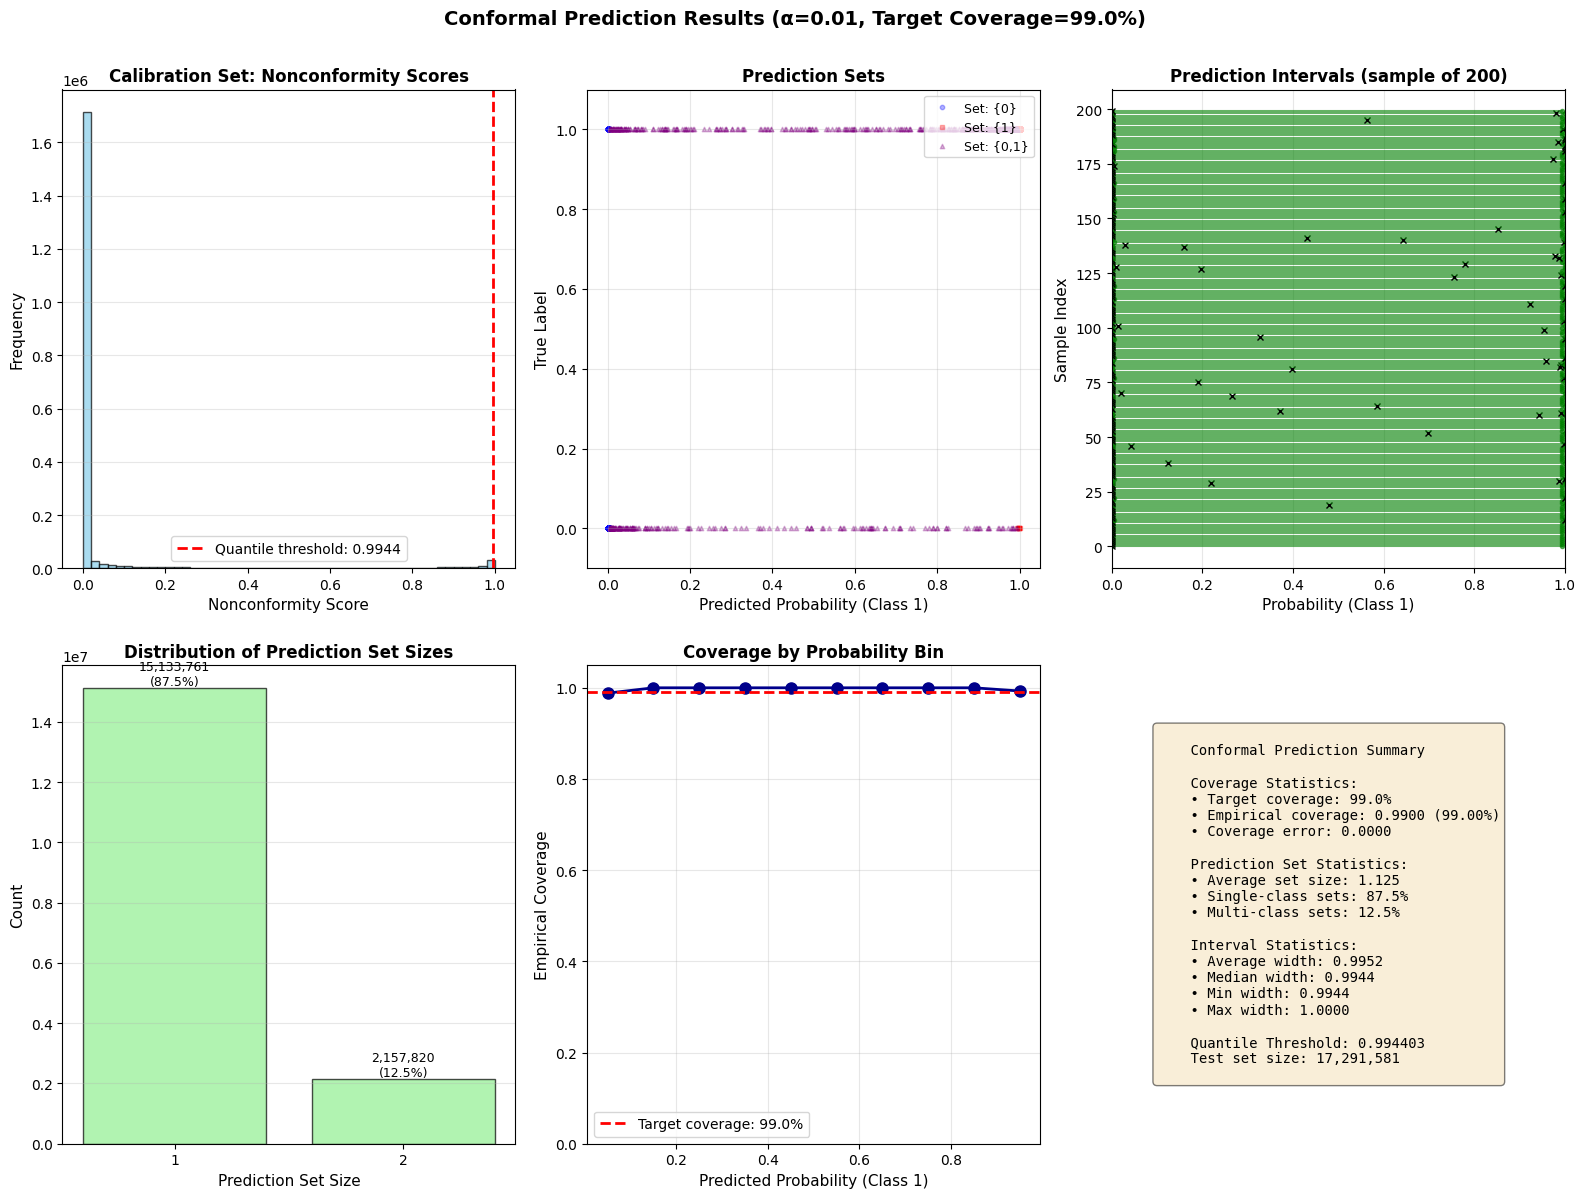

In [60]:
# Visualize conformal prediction results
cp_stats = plot_conformal_results(cp, y_true_test, y_prob_test, 
                                  prediction_sets, prediction_intervals, 
                                  n_samples_plot=5000)


In [ ]:
.shape

(2716798,)

In [62]:
prediction_intervals.shape

(17291581, 2)

In [63]:
y_prob_test

array([2.1324995e-07, 1.5841436e-01, 3.6796187e-18, ..., 1.0010696e-28,
       9.9352247e-01, 1.7448633e-20], shape=(17291581,))

In [70]:
scores_unc = scores.iloc[test_indices].iloc[np.where(prediction_sets == 1)[0]]

In [79]:
scores_unc[scores_unc['y_true'] == 1]['y_prob'].min()

0.99440324

Analyzing coverage for different alpha values...
Alpha      Target Coverage    Empirical Coverage   Avg Set Size    Avg Interval Width  
-------------------------------------------------------------------------------------
Calibration set size: 9606433
Quantile level: 0.9900
Quantile value (threshold): 0.994322
Target coverage: 99.0%
0.01       99.0%              0.9899               1.125           0.9952              
Calibration set size: 9606433
Quantile level: 0.9500
Quantile value (threshold): 0.416668
Target coverage: 95.0%
0.05       95.0%              0.9520               1.000           0.4323              
Calibration set size: 9606433
Quantile level: 0.9000
Quantile value (threshold): 0.029712
Target coverage: 90.0%
0.10       90.0%              0.9245               1.000           0.0329              
Calibration set size: 9606433
Quantile level: 0.8000
Quantile value (threshold): 0.000347
Target coverage: 80.0%
0.20       80.0%              0.8594               1.000     

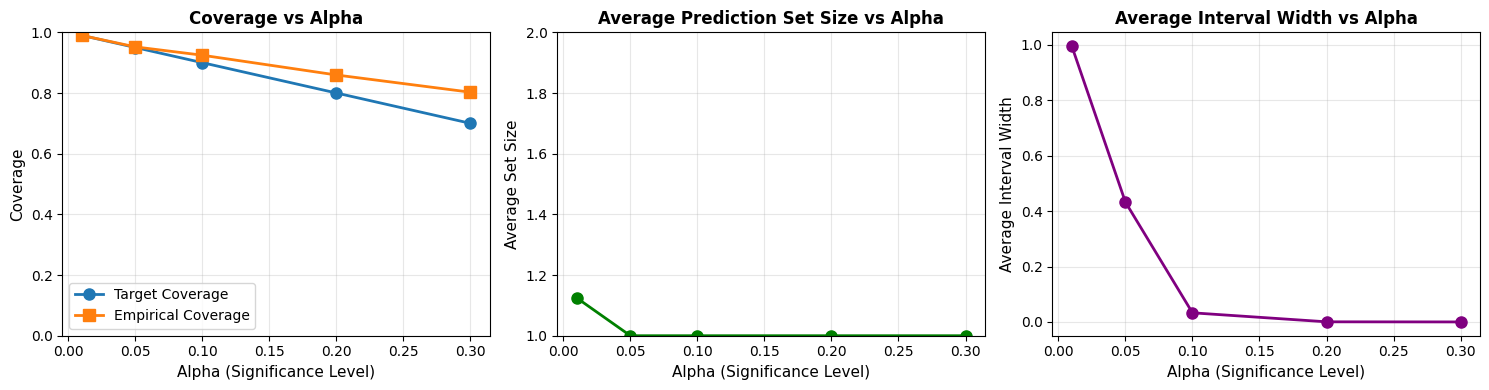


Summary: As alpha increases (lower target coverage), prediction sets become smaller
and intervals become narrower, but with lower coverage guarantee.


In [42]:
# Analyze coverage for different alpha values
alphas = [0.01, 0.05, 0.1, 0.2, 0.3]
coverage_results = []

print("Analyzing coverage for different alpha values...")
print(f"{'Alpha':<10} {'Target Coverage':<18} {'Empirical Coverage':<20} {'Avg Set Size':<15} {'Avg Interval Width':<20}")
print("-" * 85)

for alpha_val in alphas:
    cp_temp = ConformalPredictor(alpha=alpha_val)
    cp_temp.fit(y_true_cal, y_prob_cal)
    pred_sets_temp, pred_intervals_temp = cp_temp.predict(y_prob_test)
    coverage_temp = cp_temp.evaluate_coverage(y_true_test, pred_sets_temp)
    set_sizes_temp = cp_temp.get_set_size_distribution(pred_sets_temp)
    interval_widths_temp = pred_intervals_temp[:, 1] - pred_intervals_temp[:, 0]
    
    coverage_results.append({
        'alpha': alpha_val,
        'target_coverage': 1 - alpha_val,
        'empirical_coverage': coverage_temp,
        'avg_set_size': np.mean(set_sizes_temp),
        'avg_interval_width': np.mean(interval_widths_temp),
        'quantile': cp_temp.quantile
    })
    
    print(f"{alpha_val:<10.2f} {1-alpha_val:<18.1%} {coverage_temp:<20.4f} {np.mean(set_sizes_temp):<15.3f} {np.mean(interval_widths_temp):<20.4f}")

coverage_df = pd.DataFrame(coverage_results)

# Plot coverage vs alpha
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Coverage comparison
ax1 = axes[0]
ax1.plot(coverage_df['alpha'], coverage_df['target_coverage'], 'o-', 
         label='Target Coverage', linewidth=2, markersize=8)
ax1.plot(coverage_df['alpha'], coverage_df['empirical_coverage'], 's-', 
         label='Empirical Coverage', linewidth=2, markersize=8)
ax1.set_xlabel('Alpha (Significance Level)', fontsize=11)
ax1.set_ylabel('Coverage', fontsize=11)
ax1.set_title('Coverage vs Alpha', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Average set size vs alpha
ax2 = axes[1]
ax2.plot(coverage_df['alpha'], coverage_df['avg_set_size'], 'o-', 
         linewidth=2, markersize=8, color='green')
ax2.set_xlabel('Alpha (Significance Level)', fontsize=11)
ax2.set_ylabel('Average Set Size', fontsize=11)
ax2.set_title('Average Prediction Set Size vs Alpha', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_ylim([1, 2])

# Average interval width vs alpha
ax3 = axes[2]
ax3.plot(coverage_df['alpha'], coverage_df['avg_interval_width'], 'o-', 
         linewidth=2, markersize=8, color='purple')
ax3.set_xlabel('Alpha (Significance Level)', fontsize=11)
ax3.set_ylabel('Average Interval Width', fontsize=11)
ax3.set_title('Average Interval Width vs Alpha', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*85)
print("Summary: As alpha increases (lower target coverage), prediction sets become smaller")
print("and intervals become narrower, but with lower coverage guarantee.")
print("="*85)


,y_true,y_prob,y_pred
19112296,0,2.132500e-07,0
17708601,0,1.584144e-01,0
12423795,0,3.679619e-18,0
17829313,0,6.055855e-04,0
16740815,0,8.232540e-07,0
...,...,...,...
9628519,0,2.862482e-15,0
14586186,0,1.127674e-12,0
2234489,0,1.001070e-28,0
13315092,1,9.935225e-01,1


<Axes: >

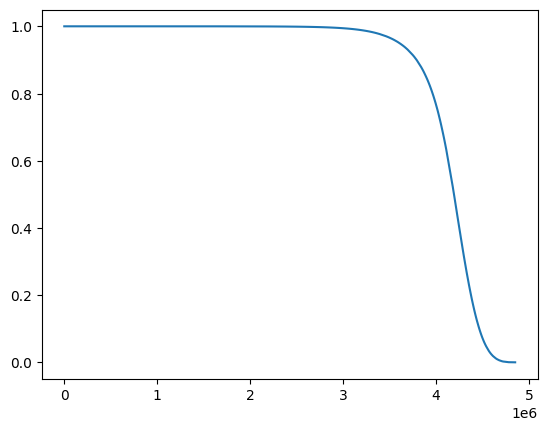

In [86]:
scores[scores['y_true'] == 1].sort_values('y_prob', ascending=False).reset_index()['y_prob'][::-1].plot()